In [2]:
jet.GetEntry(100)

749

In [2]:
import ROOT as rt
import numpy as np
import math
import mxnet as mx
import datetime
start=datetime.datetime.now()
#record=mx.recordio.MXRecordIO('tmp.rec','w')
jetset=[]
labels=[]
maxx=0.4
maxy=0.4
arnum=16
bx=2*maxx/(2*arnum+1)
by=2*maxy/(2*arnum+1)
read=rt.TFile('jet2.root')
jet=rt.gDirectory.Get('jetAnalyser/jetAnalyser')
entries=jet.GetEntriesFast()
overlap=np.zeros(shape=(3,2*arnum+1,2*arnum+1))
for ent in range(entries):
    if ent>1500000:
        break
    jet.GetEntry(ent)
    #if jet.pt<300 or jet.pt>400:
    #    continue
    if jet.partonId==21:
        labels.append(1)
    else:
        labels.append(0)
    palet=np.zeros(shape=(3,2*arnum+1,2*arnum+1))
    r=0
    g=0
    b=0
    for i in range(len(jet.dau_pt)):
        x=int(math.floor((jet.dau_deta[i]/bx)+0.5)+arnum)
        if x<0 or x>2*arnum:
            continue
        y=int(math.floor((jet.dau_dphi[i]/by)+0.5)+arnum)
        if y<0 or y>2*arnum:
            continue
        pt=jet.dau_pt[i]
        if jet.dau_charge[i]==0:
            palet[1][x][y]+=pt
            #overlap[1][x][y]+=pt
            if palet[1][x][y]>g:
                g=palet[1][x][y]
        else:
            palet[0][x][y]+=pt
            palet[2][x][y]+=1
            #overlap[0][x][y]+=pt
            #overlap[2][x][y]+=1
            if palet[0][x][y]>r:
                r=palet[0][x][y]
            if palet[2][x][y]>b:
                b=palet[2][x][y]
            #pass
    #record.write(palet)
    for i in range(2*arnum+1):
        for j in range(2*arnum+1):
            if r!=0:
                palet[0][i][j]=255*palet[0][i][j]/r
            if g!=0:
                palet[1][i][j]=255*palet[1][i][j]/g
            if b!=0:
                palet[2][i][j]=255*palet[2][i][j]/b
    jetset.append(palet)
    overlap=np.add(overlap,palet)
jetset=np.array(jetset)

Welcome to JupyROOT 6.08/06


In [3]:
len(jetset)

14948

In [31]:
for i in range(2*arnum+1):
        for j in range(2*arnum+1):
            overlap[1][i][j]=255*overlap[1][i][j]/r
            overlap[0][i][j]=255*overlap[0][i][j]/g
            overlap[2][i][j]=255*overlap[2][i][j]/b
labels=np.array(labels)
jetset=np.array(jetset)
record.close()
print datetime.datetime.now()-start

0:00:54.213581


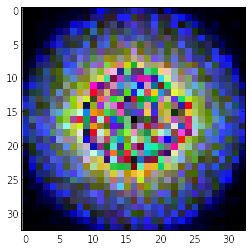

[0 0 1 ..., 1 0 0]


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
bkb=np.swapaxes(overlap,0,1)
bkb=np.swapaxes(bkb,1,2)
plt.imshow(bkb,interpolation='none')
print labels
plt.show()

In [25]:
import mxnet as mx
import numpy as np
f=open("ccdata06_14.csv","r")
labels=[]
data1=[]
i=0
while True:
    i+=1
    flav=f.readline()
    line=f.readline()
    if not line: break
    flav=eval(flav)[0]
    #if(i>5000):break
    #if(eval(flav)!=int): break
    if flav==21:
        labels.append(0)
    else:
        labels.append(1)
    if(i==1):
        data1.append(np.reshape(eval('['+line+']'),(33,33,3)))
    else:
        data1=np.add(data1,np.reshape(eval('['+line+']'),(33,33,3)))
#data1=np.reshape(np.array(data1),(len(data1),1089*3))
print data1.shape
labels=np.array(labels)
f.close()

rbuf=0
gbuf=0
bbuf=0
for i in range(33):
    for j in range(33):
        if(data1[0][i][j][0]>rbuf):
            rbuf=data1[0][i][j][0]
        if(data1[0][i][j][1]>gbuf):
            gbuf=data1[0][i][j][1]
        if(data1[0][i][j][2]>bbuf):
            bbuf=data1[0][i][j][2]
for i in range(33):
    for j in range(33):
        data1[0][i][j][0]=255*data1[0][i][j][0]/rbuf
        data1[0][i][j][1]=255*data1[0][i][j][1]/gbuf
        data1[0][i][j][2]=255*data1[0][i][j][2]/bbuf

(1, 33, 33, 3)


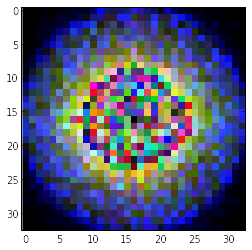

[1 1 0 ..., 0 1 1]


In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.swapaxes(data1[0],0,1),interpolation='none')
print labels
plt.show()

In [4]:
np.fromstring(np.ndarray.tostring(palet))

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [6]:
jet.GetEntry(10)
print jet.partonId, jet.dau_deta[1]

2 -0.0526000261307


In [4]:
import mxnet as mx
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve, average_precision_score
batch_size=100
data_train, data_test, label_train, label_test = train_test_split(jetset.reshape(len(jetset),3*33*33), labels, test_size=0.3,
                                                                    random_state=random.randrange(0,10000))
#data_train=data1[:int(len(data1)*0.7)]
#data_test=data1[int(len(data1)*0.7):]
#label_train=labels[:int(len(labels)*0.7)]
#label_test=labels[int(len(labels)*0.7):]
data_train=data_train.reshape(len(data_train),3,33,33)
data_test=data_test.reshape(len(data_test),3,33,33)
print data_train.shape
train_iter = mx.io.NDArrayIter(data_train, label_train, batch_size, shuffle=False)
val_iter = mx.io.NDArrayIter(data_test, label_test, batch_size)

data = mx.sym.var('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="relu")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="relu")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="relu")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=2)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
#mx.viz.plot_network(lenet)

AttributeError: 'list' object has no attribute 'reshape'

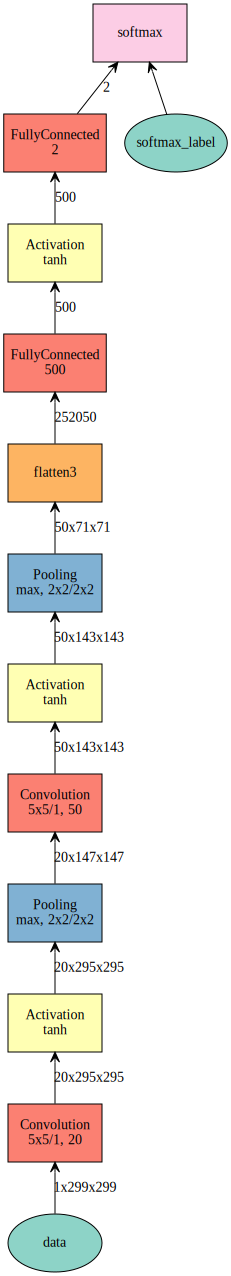

In [23]:
mx.viz.plot_network(lenet, shape={"data":(1, 1, 299, 299)}, node_attrs={"shape":'rect',"fixedsize":'false'})

In [18]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
# train with the same 
#optimizer_params={'learning_rate':0.5,'beta1':0.1,'beta2':0.111},
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=30)

[00:16:31] src/operator/././cudnn_algoreg-inl.h:65: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
INFO:root:Epoch[0] Train-accuracy=0.545714
INFO:root:Epoch[0] Time cost=0.288
INFO:root:Epoch[0] Validation-accuracy=0.534889
INFO:root:Epoch[1] Train-accuracy=0.561619
INFO:root:Epoch[1] Time cost=0.263
INFO:root:Epoch[1] Validation-accuracy=0.639778
INFO:root:Epoch[2] Train-accuracy=0.645333
INFO:root:Epoch[2] Time cost=0.260
INFO:root:Epoch[2] Validation-accuracy=0.637778
INFO:root:Epoch[3] Train-accuracy=0.656667
INFO:root:Epoch[3] Time cost=0.261
INFO:root:Epoch[3] Validation-accuracy=0.650222
INFO:root:Epoch[4] Train-accuracy=0.665333
INFO:root:Epoch[4] Time cost=0.263
INFO:root:Epoch[4] Validation-accuracy=0.656444
INFO:root:Epoch[5] Train-accuracy=0.672857
INFO:root:Epoch[5] Time cost=0.262
INFO:root:Epoch[5] Validation-accuracy=0.660667
INFO:root:Epoch[6] Train-accuracy

In [28]:
lenet_model.save_checkpoint(prefix='300pt',epoch=5)

INFO:root:Saved checkpoint to "300pt-0005.params"


In [19]:
valpred=lenet_model.predict(val_iter).asnumpy()[:,1]

trainpred=lenet_model.predict(train_iter).asnumpy()[:,1]

t_fpr, t_tpr, _ = roc_curve( label_train, trainpred)
e_fpr, e_tpr, _ = roc_curve( label_test, valpred )

In [61]:
diff = label_train - trainpred

In [64]:
diff = abs(diff)

In [77]:
diff.sum() / len(diff)

0.49942159571318262

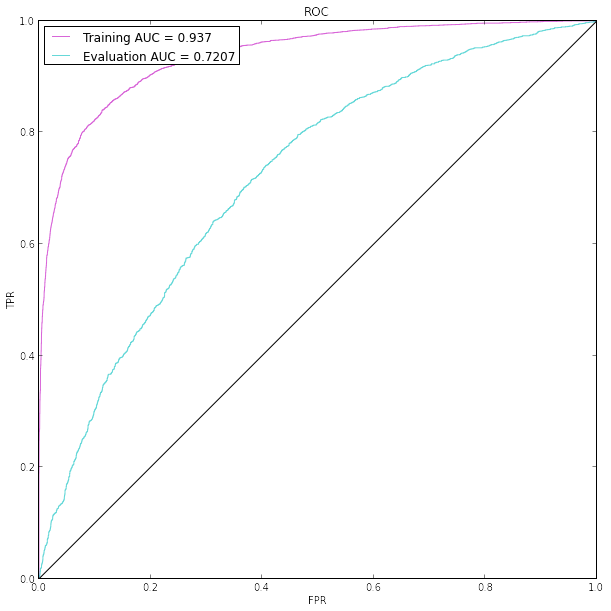

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure( figsize=(10, 10) )
train_auc = np.around( auc(t_fpr, t_tpr), 4 )
eval_auc = np.around( auc(e_fpr, e_tpr), 4 )
plt.title( "ROC" )
plt.xlabel( "FPR" )
plt.ylabel( "TPR" )
plt.plot( t_fpr, t_tpr, alpha=0.6, c='m', label="Training AUC = {}".format( train_auc ) )
plt.plot( e_fpr, e_tpr, alpha=0.6, c='c', label="Evaluation AUC = {}".format( eval_auc ) )
plt.plot( [0,1], [0, 1], c='k', alpha=1 )
plt.legend( loc=2 )
plt.show()